<a href="https://colab.research.google.com/github/PradeepBilla/Colab/blob/main/Copy_of_NLP_Project_Full_Code_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

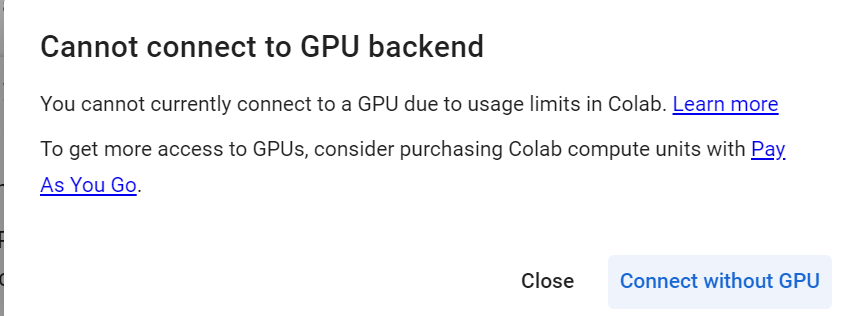

## **Installing and Importing Necessary Libraries**

In [ ]:

!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir -q




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 309.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 150.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 141.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 321.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 287.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for llama-cpp-python (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llama-cpp-python
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (llama-cpp-python

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

# Importing library for data manipulation
import pandas as pd
import numpy as np

# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download


# Importing the json library
import json

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# to split the data
from sklearn.model_selection import train_test_split

# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score



# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock_news = pd.read_csv("/content/sample_data/stock_news.csv")

In [ ]:
# creating a copy of the data
data = stock_news.copy()


## **Data Overview**

In [ ]:
#Printing the first few rows.
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


## **Checking the shape of the dataset**


In [ ]:
data.shape

(349, 8)



*   The dataset has 349 rows and 8 columns


## **Checking for Missing Values**


In [ ]:
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


*   There are no missing values in the data.


## **Checking for duplicates**

In [ ]:
data.duplicated().sum()

0

*   There are no duplicate values in the data.


## **Exploratory Data Analysis**

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

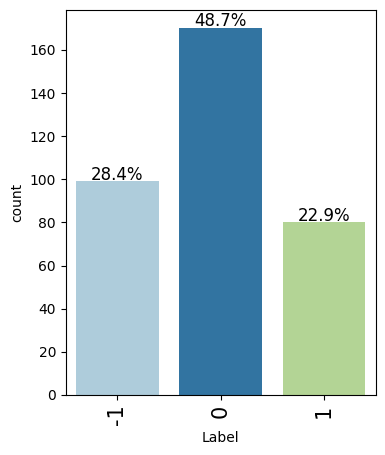

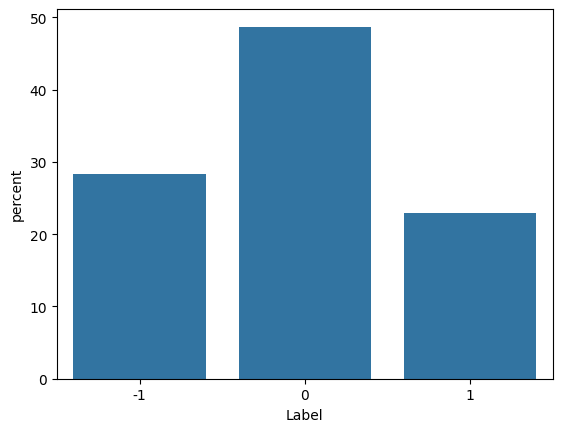

In [ ]:
sns.countplot(data=data, x="Label", stat="percent");

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])  # to convert the 'Date' column in the 'stock' DataFrame to datetime format.

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

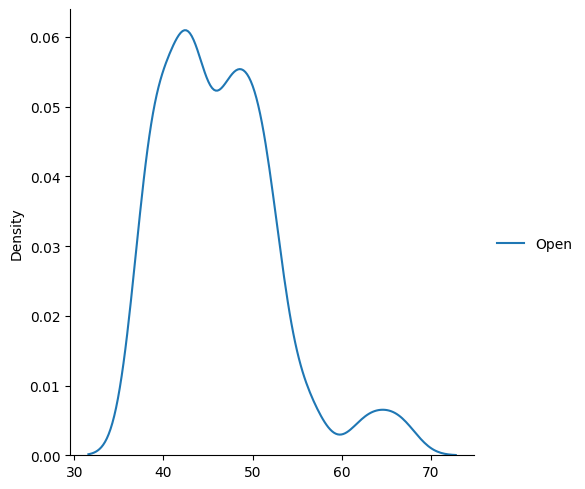

In [ ]:
sns.displot(data=data[['Open']], kind="kde", palette="tab10"); # Complete the code to plot a density plot of ["Open","High","Low","Close"] all in a single plot

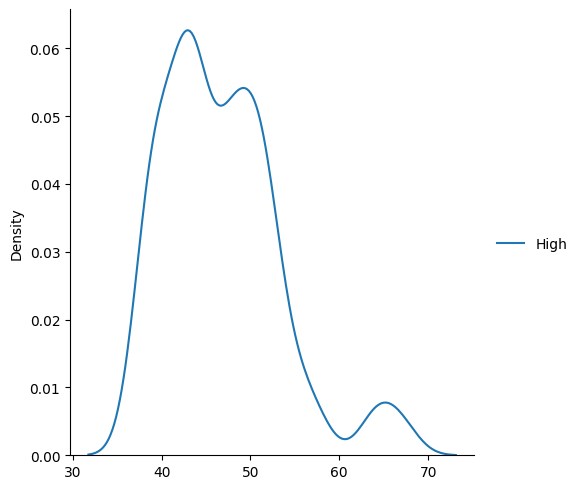

In [ ]:
sns.displot(data=data[['High']], kind="kde", palette="tab10");

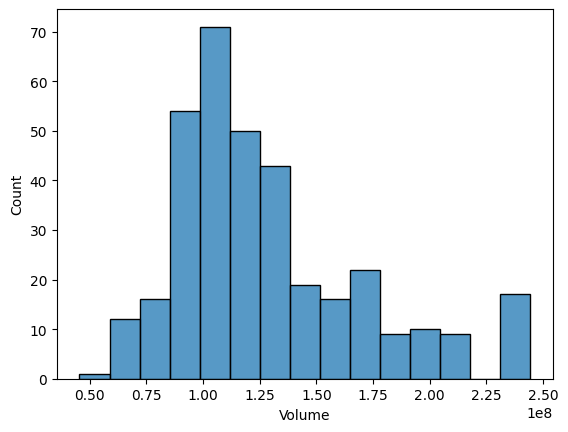

In [ ]:
sns.histplot(data, x='Volume'); # Complete the code to plot a histogram of Volume

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

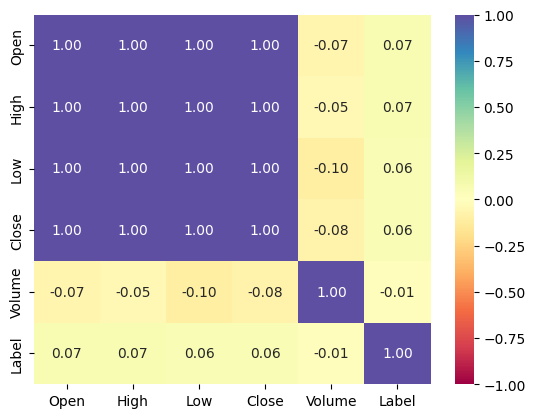

In [ ]:

sns.heatmap(
    data.select_dtypes(include=['number']).corr(),  # Select numeric columns and calculate the correlation matrix
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="Spectral"
);


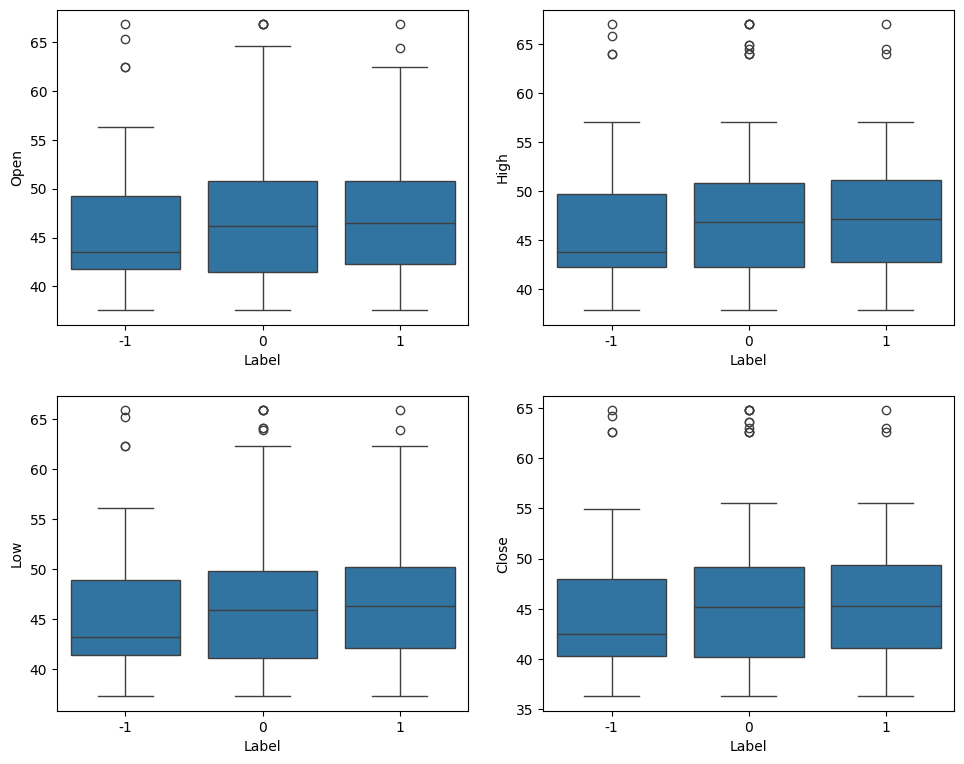

In [ ]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=data, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

## **Data Preprocessing**

In [ ]:
data["Date"].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


In [ ]:
# Select all rows where 'Date' is before '2019-04-01'
X_train = data[(data['Date'] < '2019-04-01')].reset_index()

# Select all rows where 'Date' is from '2019-04-01' to '2019-04-16' (excluded)
X_val = data[(data['Date'] >= '2019-04-01') & (data['Date'] < '2019-04-16')].reset_index()

# Select all rows where 'Date' is from '2019-04-16' till the end
X_test = data[data['Date'] >= '2019-04-16'].reset_index()

NameError: name 'data' is not defined

In [ ]:
# Select 'Label' column as the target variable
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()


In [ ]:

print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 9)
Validation data shape (21, 9)
Test data shape  (42, 9)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


# Word Embeddings

In [ ]:
words_list = [item.split(" ") for item in data['News'].values]
all_words = [word for sublist in words_list for word in sublist]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


In [ ]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-4.61215340e-03,  3.81439142e-02,  7.47901155e-03,  1.14809955e-02,
        1.70915120e-03, -5.77968210e-02,  2.84311380e-02,  8.67084190e-02,
        3.87548073e-03, -2.15729289e-02,  6.41624350e-03, -2.15880796e-02,
       -5.06790867e-03,  1.58912111e-02, -2.48800479e-02, -2.73131132e-02,
        2.38712095e-02, -4.32497077e-03,  6.78942911e-03, -2.42324453e-02,
       -2.27517169e-02,  7.97891803e-03,  2.98970938e-02,  1.42854322e-02,
        2.47016102e-02,  1.20530580e-03, -3.46511602e-02,  8.31171963e-03,
       -2.87539568e-02, -4.14497890e-02,  9.49276146e-03, -2.73937471e-02,
        5.22901025e-03, -8.17989092e-03, -1.87049550e-03,  2.29445323e-02,
        1.28874928e-02, -3.41846794e-02, -2.81799259e-03, -1.21468389e-02,
       -2.05502249e-02,  3.39775882e-03, -6.05338428e-04, -2.11149566e-02,
        1.99507512e-02,  3.79260033e-02,  9.44973901e-03,  1.78321581e-02,
        4.06961226e-05,  2.32672282e-02,  1.15651926e-02, -8.93667806e-03,
       -2.11233255e-02,  

In [ ]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([-1.26954832e-03,  5.49125252e-03,  3.13833542e-03,  1.99256139e-03,
       -1.07183761e-03, -1.17887044e-02,  6.80755870e-03,  1.59658510e-02,
       -1.94939657e-03, -2.21714703e-03, -2.35582329e-03, -3.69705888e-03,
        7.08479783e-04, -6.11767027e-05, -4.25119465e-03, -1.96993188e-03,
        7.49570318e-03,  1.82193774e-03,  3.80724925e-03, -2.73804553e-03,
       -5.90073224e-03,  2.81839492e-03,  4.17952612e-03, -8.50849028e-04,
        1.46462210e-03, -1.14440499e-03, -7.19891209e-03,  2.29954021e-03,
       -6.79683033e-03, -9.96777788e-03, -2.02023122e-03, -6.69653108e-03,
        3.02464212e-03, -2.62372196e-03, -2.71538226e-03,  5.97277749e-03,
       -1.21093472e-05, -5.54551790e-03, -1.37613039e-04, -2.97668367e-03,
       -5.94479032e-03,  7.47327867e-04,  1.36684754e-03, -4.07966459e-03,
        4.02667094e-03,  4.02458850e-03, -4.86644480e-04,  1.24413054e-03,
       -7.45962534e-05,  1.13859726e-03,  4.65976214e-03, -4.13122261e-03,
       -4.27682605e-03,  

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
import time

start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.8120806217193604


In [ ]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


In [ ]:
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt.word2vec'

glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [ ]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

# Apply GloVe on the 'News' column for training, validation, and test sets
X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))


Time taken  31.832531213760376


In [ ]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


## Sentiment Analysis

### Model Definition

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
start = time.time()

# Apply Sentence Transformer encoding on the 'News' column
X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ", (end-start))


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  1.659938097000122


## **Sentiment Analysis**

In [ ]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)


(286, 384) (21, 384) (42, 384)




*   Each news content has been converted to a 384-dimensional vector.




In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [ ]:
# Building the model


base_wv = RandomForestClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=42)

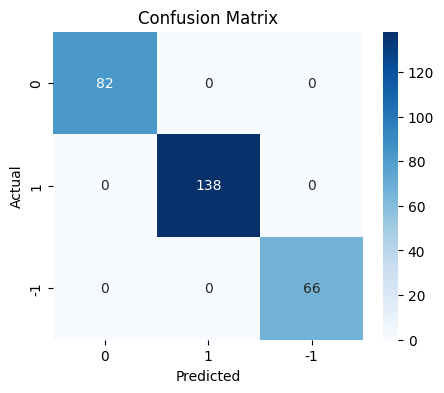

In [ ]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

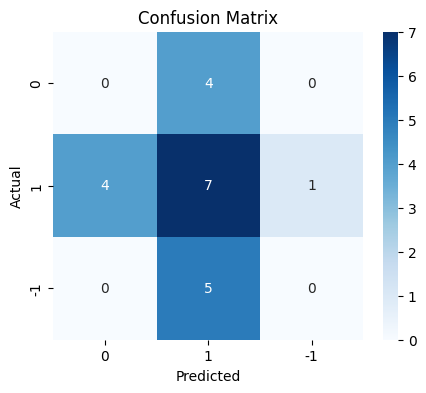

In [ ]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.333333  0.333333       0.25  0.285714


### Base Model - GloVe

In [ ]:
base_wv = RandomForestClassifier(random_state=42)
base_wv.fit(X_train_gl, y_train)  # Fit the model on the train data

RandomForestClassifier(random_state=42)

Text(0.5, 1.0, 'Confusion Matrix')

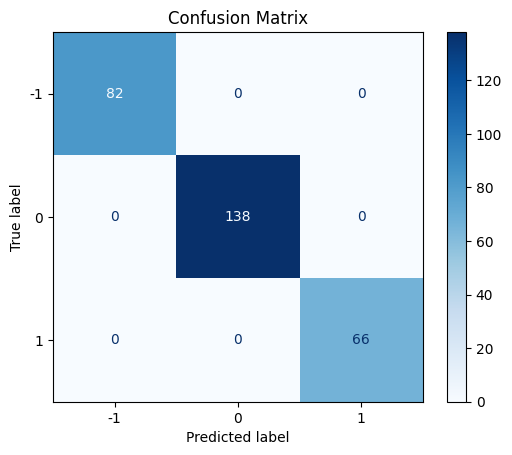

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for the train data
disp = ConfusionMatrixDisplay.from_estimator(
    base_wv, X_train_gl, y_train, cmap='Blues'
)

# To display the plot
disp.ax_.set_title("Confusion Matrix")

Text(0.5, 1.0, 'Validation Confusion Matrix')

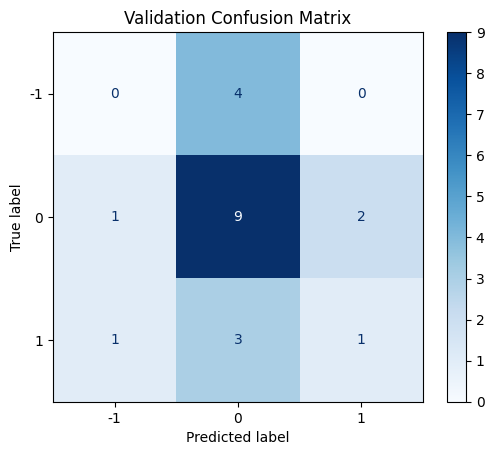

In [ ]:
# Plot confusion matrix for the validation data
disp = ConfusionMatrixDisplay.from_estimator(
    base_wv, X_val_gl, y_val, cmap='Blues'
)

# To display the plot
disp.ax_.set_title("Validation Confusion Matrix")

In [ ]:
# Calculating different metrics on training data
base_train_gl = model_performance_classification_sklearn(base_wv, X_train_gl, y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
# Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_wv, X_val_gl, y_val)
print("Validation performance:\n", base_val_gl)

NameError: name 'model_performance_classification_sklearn' is not defined

## **Sentence Transformer**

In [ ]:
base_wv = RandomForestClassifier(random_state=42)
base_wv.fit(X_train_st, y_train)  # Fit the model on the train data

NameError: name 'RandomForestClassifier' is not defined

Text(0.5, 1.0, 'Training Confusion Matrix')

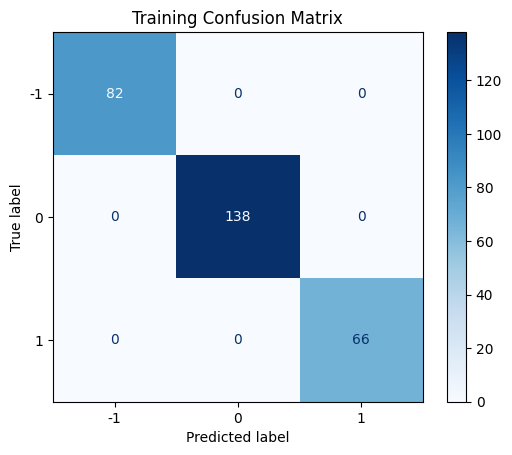

In [ ]:
# Plot confusion matrix for the train data
disp = ConfusionMatrixDisplay.from_estimator(
    base_wv, X_train_st, y_train, cmap='Blues'
)

# Display the plot
disp.ax_.set_title("Training Confusion Matrix")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for the validation data
disp = ConfusionMatrixDisplay.from_estimator(
    base_wv, X_val_st, y_val, cmap='Blues'
)

# Display the plot
disp.ax_.set_title("Validation Confusion Matrix")

NameError: name 'base_wv' is not defined

In [ ]:
# Calculate different metrics on training data
base_train_st = model_performance_classification_sklearn(base_wv, X_train_st, y_train)
print("Training performance:\n", base_train_st)


NameError: name 'model_performance_classification_sklearn' is not defined

In [ ]:
# Calculate different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_wv, X_val_st, y_val)
print("Validation performance:\n", base_val_st)

### Tuned Model - Word2Vec

In [ ]:
start = time.time()


tuned_wv = RandomForestClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

In [ ]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

In [ ]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

In [ ]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

In [ ]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

### Tuned Model - GloVe

In [ ]:
start = time.time()


tuned_wv = RandomForestClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(_____, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

In [ ]:
# Fit the best model (from grid search) on the training data
tuned_gl.fit(X_train_gl, y_train)

In [ ]:
# Plot confusion matrix for the train data
plot_confusion_matrix(tuned_gl, X_train_gl, y_train, cmap='Blues')

In [ ]:
# Plot confusion matrix for the validation data
plot_confusion_matrix(tuned_gl, X_val_gl, y_val, cmap='Blues')

In [ ]:
# Calculate different metrics on training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl, X_train_gl, y_train)
print("Training performance:\n", tuned_train_gl)


In [ ]:
# Calculate different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl, X_val_gl, y_val)
print("Validation performance:\n", tuned_val_gl)


### Tuned Model - Sentence Transformer

In [ ]:
start = time.time()

# Choose the type of classifier.


tuned_wv = RandomForestClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(_____, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

In [ ]:
# Fit the best algorithm to the data
tuned_st.fit(X_train_st, y_train)

In [ ]:
# Plot confusion matrix for the training data
plot_confusion_matrix(tuned_st, X_train_st, y_train, cmap='Blues')


In [ ]:
# Plot confusion matrix for the validation data
plot_confusion_matrix(tuned_st, X_val_st, y_val, cmap='Blues')


In [ ]:
# Calculate different metrics on the training data
tuned_train_st = model_performance_classification_sklearn(tuned_st, X_train_st, y_train)
print("Training performance:\n", tuned_train_st)


In [ ]:
# Calculate different metrics on the validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st, X_val_st, y_val)
print("Validation performance:\n", tuned_val_st)


### Model Performance Summary and Final Model Selection

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

In [ ]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

### Model Performance Check on Test Data

In [ ]:
# Use the final model (e.g., tuned_st) and the test data (X_test_st and y_test)
plot_confusion_matrix(tuned_st, X_test_st, y_test, cmap='Blues')

# Optionally, you can add a title or other plot customizations
import matplotlib.pyplot as plt
plt.title('Confusion Matrix for Final Model (Tuned Sentence Transformer)')
plt.show()

In [ ]:
# Calculating different metrics on test data for the final model
final_model_test = model_performance_classification_sklearn(tuned_st, X_test_st, y_test)
print("Test performance for the final model:\n", final_model_test)


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for llama-cpp-python (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llama-cpp-python
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (llama-cpp-python)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

#### Loading the model

In [ ]:
from huggingface_hub import hf_hub_download

model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

# Download the model
model_path = hf_hub_download(
    repo_id=model_name_or_path,  # Repo ID of the model
    filename=model_basename      # The specific model file to download
)

print("Model downloaded to:", model_path)

In [ ]:
#uncomment the below snippet of code if the runtime is connected to GPU.
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=_____, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=_____, #Complete the code to set the value for temperature.
      top_p=_____, #Complete the code to set the value for top_p
      top_k=_____, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

##### Checking the model output on the weekly data

##### Formatting the model output

## **Conclusions and Recommendations**

-




<font size=6 color='blue'>Power Ahead</font>
___